## **1.0 Imports**

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

In [5]:
#pd.set_option('display.float_format', lambda x: '%.2f' % x)
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [13, 6]
    plt.rcParams['font.size'] = 20
    
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

##### **1.1 Load Data and Treatment**

In [6]:
data = pd.read_excel('./data/exchange_rate.xlsx')
data.shape

(7009, 2)

In [7]:
data.head(15)

,JBDCBRL Index,PX_LAST
0,1994-01-04,81.93
1,1994-01-05,82.30
2,1994-01-06,82.65
3,1994-01-07,82.78
4,1994-01-10,84.58
5,1994-01-11,86.21
6,1994-01-12,86.18
7,1994-01-13,85.00
8,1994-01-14,84.98
9,1994-01-18,88.56


##### **1.2 Rename columns and rows**

In [8]:
data = data.rename({'JBDCBRL Index': 'date', 'PX_LAST': 'value'}, axis=1)

##### **1.3 Data types**

In [9]:
data.dtypes

date     datetime64[ns]
value           float64
dtype: object

##### **1.4 Check NaN**

In [10]:
data.isna().sum()

date     0
value    0
dtype: int64

##### **1.5 Numerical Analysis**

In [11]:
num_attributes = data.select_dtypes(include=['float'])

In [12]:
# Central tendency - mean, median
#mean
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
#median
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - desvio, minimo, maximo, range, skew, kutosi

d1 = pd.DataFrame(num_attributes.apply(np.std)).T

d2 = pd.DataFrame(num_attributes.apply(np.min)).T

d3 = pd.DataFrame(num_attributes.apply(np.max)).T

d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T

d5 = pd.DataFrame(num_attributes.apply(lambda x : x.skew())).T

d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concat 
h = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
h.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 

In [13]:
h

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,value,42.43,109.69,67.26,79.923703,79.85,16.617289,-0.073575,-1.051584


##### **2.0 Data Visualization**

In [14]:
df2 = data.copy()
df2 = df2.loc[(df2['date'] > '2008-01-01') & (df2['date'] < '2021-12-31')]
df2.head(10)

,date,value
3493,2008-01-02,91.56
3494,2008-01-03,92.46
3495,2008-01-04,91.92
3496,2008-01-07,91.65
3497,2008-01-08,92.09
3498,2008-01-09,91.38
3499,2008-01-10,91.65
3500,2008-01-11,92.37
3501,2008-01-14,92.86
3502,2008-01-15,92.18


Text(0.5, 0, 'Data')

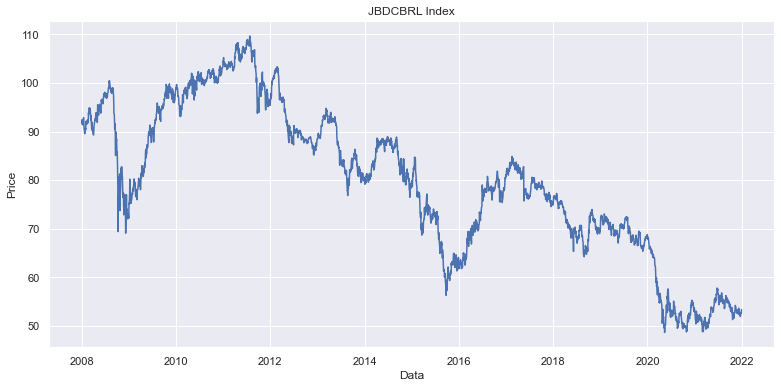

In [15]:
sns.lineplot(x = 'date', y='value', data=df2)
plt.title('JBDCBRL Index')
plt.ylabel('Price')
plt.xlabel('Data')

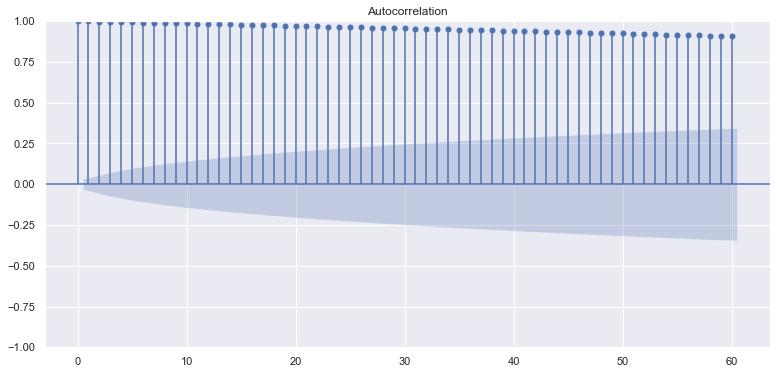

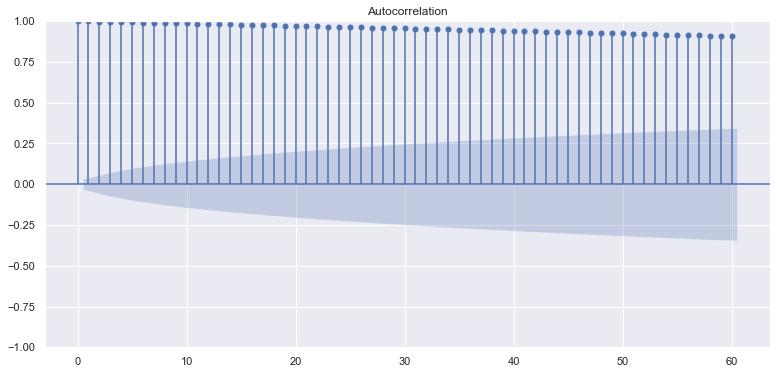

In [16]:
plot_acf(df2['value'], lags=60)

##### **2.1 ADF Test - In nivel**

In [17]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [18]:
adf_test(df2['value'])

Results of Dickey-Fuller Test:
Test Statistic                   -0.744153
p-value                           0.834979
#Lags Used                        5.000000
Number of Observations Used    3509.000000
Critical Value (1%)              -3.432215
Critical Value (5%)              -2.862364
Critical Value (10%)             -2.567209
dtype: float64


##### **2.2 KPSS - In nivel**

In [19]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [20]:
kpss_test(df2['value'])

Results of KPSS Test:
Test Statistic            7.038882
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\victo\Music\Projetos\Python\tcc\venv\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


#### **3.0 Diferenciação e modelagem**

In [21]:
df3 = df2.copy()

Text(0.5, 0, 'Data')

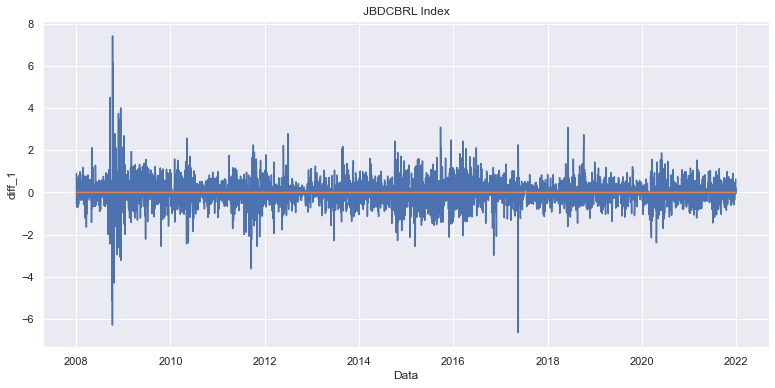

In [22]:
#Diff
df3['diff_1'] = df3['value'].diff(periods=1)
df3['zero'] = 0

#Plot series in 1° diff
sns.lineplot(x = 'date', y='diff_1', data=df3)
sns.lineplot(x = 'date', y='zero', data=df3)

plt.title('JBDCBRL Index')
plt.xlabel('Data')


##### **3.1 Testes em 1° diferença**

In [23]:
df3 = df3.dropna()

In [24]:
adf_test(df3['diff_1'])

Results of Dickey-Fuller Test:
Test Statistic                  -28.486558
p-value                           0.000000
#Lags Used                        4.000000
Number of Observations Used    3509.000000
Critical Value (1%)              -3.432215
Critical Value (5%)              -2.862364
Critical Value (10%)             -2.567209
dtype: float64


In [25]:
kpss_test(df3['diff_1'])

Results of KPSS Test:
Test Statistic            0.079358
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\victo\Music\Projetos\Python\tcc\venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [26]:
df3 = df3.dropna()

c:\Users\victo\Music\Projetos\Python\tcc\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


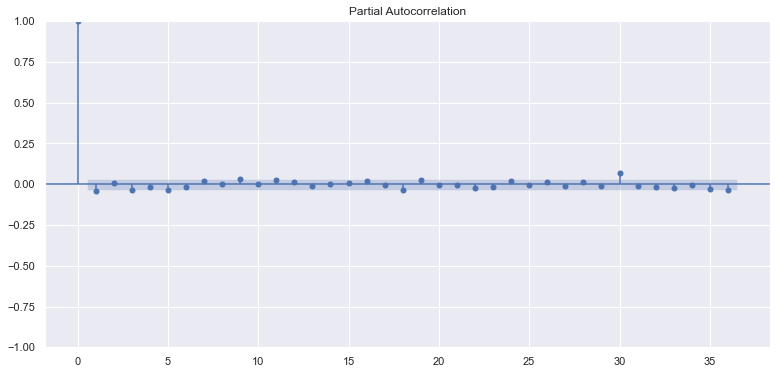

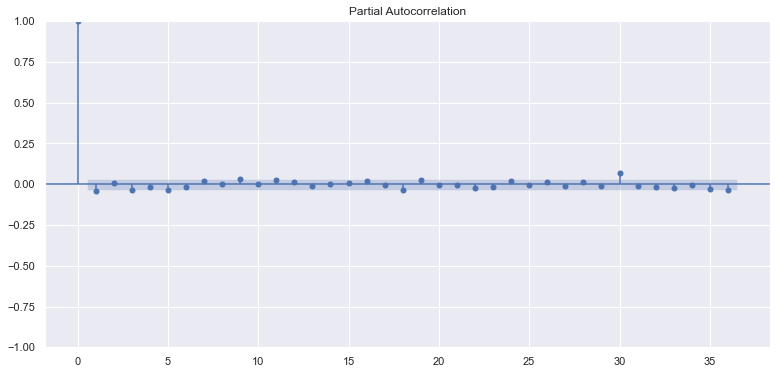

In [27]:
plot_pacf(df3['diff_1'])

In [41]:
acorr_ljungbox(df3['diff_1'], lags=[30], return_df = True)

,lb_stat,lb_pvalue
30,60.23576,0.000862
